# Getting Started in Machine Learning

### Chapter 19 Tree Ensemble Models

This notebook contains examples from the book:

Getting Started in Machine Learning: Easy Recipes for Python 3, Scikit-Learn, Jupyter (2019) by Bella Romeo, Sherwood Forest Books, Los Angeles, CA, USA, ISBN-13: 978-0-9966860-6-8

(c) Copyright 2019.

<font style="font-size:xx-small; font-family:courier;">

    This notebook is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program. If not, see <https://www.gnu.org/licenses/>.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Read wine clasification data

In [2]:
white=pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv",
               sep=";")
print(white.columns)

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')


In [3]:
white[:3]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6


# basic decision tree on wine quality

In [4]:
Y=np.array(white["quality"])
X=np.array(white)[:,:-1]

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier, \
   BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split

/home/mathman/.local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Evaluate a single classifier by doing nruns training splits

Return value is the mean and standard deviation of the error

In [6]:
def evaluate_classifier(clf, X, Y, nruns):
    errs=[]
    for j in range(nruns):
        XTRAIN, XTEST, YTRAIN, YTEST=train_test_split(X,Y)
        clf.fit(XTRAIN, YTRAIN)
        YP=clf.predict(XTEST)
        errs.append(1-accuracy_score(YTEST,YP))
    return(np.mean(errs), np.std(errs))

#### Define "Truncated Decision Tree" as a tree that stops after at most 3 devisions

In [7]:
DT=DecisionTreeClassifier(max_depth=3)
DT5=DecisionTreeClassifier(max_depth=5)
DTTmu,DTTsig=evaluate_classifier(DT,X,Y,25)
DTT5mu,DTT5sig=evaluate_classifier(DT5,X,Y,25)
print("Max Depth = 3: ", round(DTTmu,3), round(DTTsig,3))
print("Max Depth = 5: ", round(DTT5mu,3), round(DTT5sig,3))

Max Depth = 3:  0.479 0.015
Max Depth = 5:  0.468 0.01


#### Define "Full Decision Tree" as one that continues until no further splitting is possible

In [8]:
DT=DecisionTreeClassifier(max_depth=None)
DTFullmu, DTFullsig=evaluate_classifier(DT,X,Y,25)
print("Max Depth = No Limit: ", round(DTFullmu,3), round(DTFullsig,3))

Max Depth = No Limit:  0.404 0.011


In [9]:
import graphviz
import pydotplus
from IPython.display import Image
from sklearn.tree import export_graphviz

In [10]:
np.unique(Y)

array([3, 4, 5, 6, 7, 8, 9])

In [11]:
dot5= export_graphviz(DT5, 
        out_file=None, rotate=True, 
        impurity=False, 
        feature_names=np.array(white.columns)[:-1].tolist(),
        class_names=list(map(str,np.unique(Y).tolist())),
        filled=True, rounded=True, special_characters=True)

In [12]:
g=pydotplus.graph_from_dot_data(dot5)

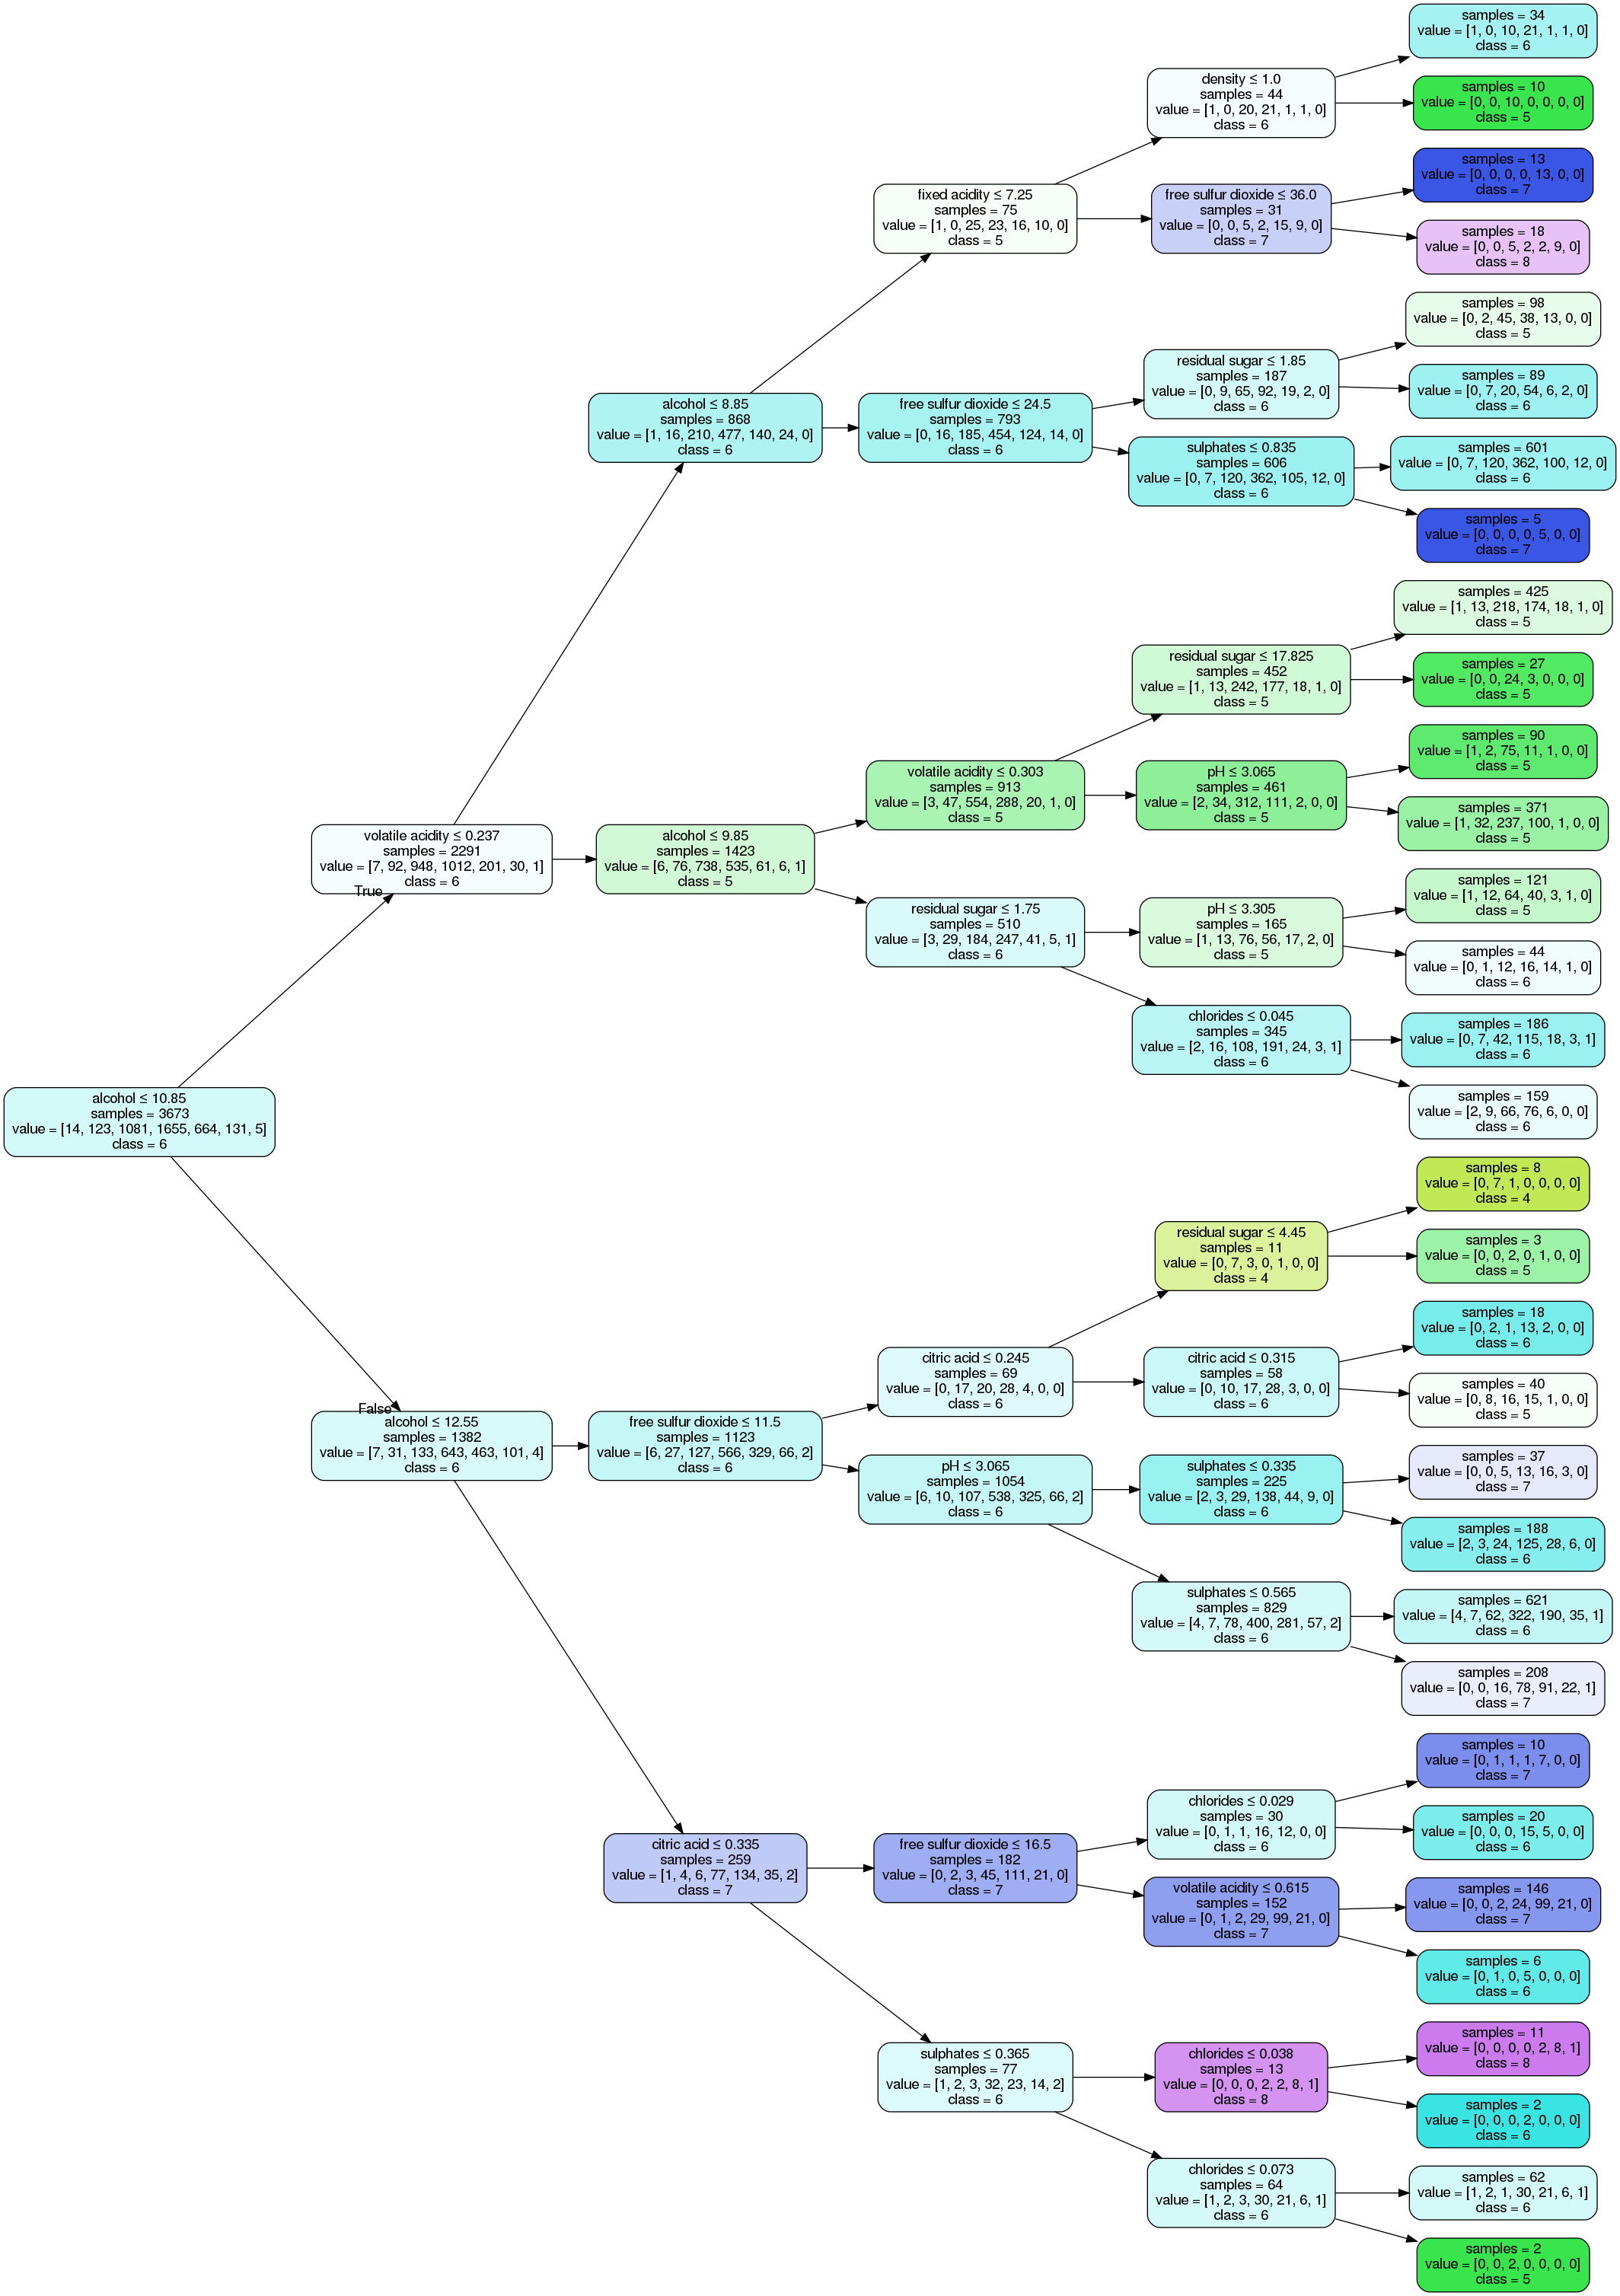

In [13]:
Image(g.create_png())

In [14]:
g.write_pdf("white-wine-class-L5.pdf")

True

### Typical Confusion Matrix

In [15]:
DT=DecisionTreeClassifier(max_depth=None)
XTRAIN,XTEST,YTRAIN,YTEST=train_test_split(X,Y)
DT.fit(XTRAIN,YTRAIN)
YP=DT.predict(XTEST)
print(confusion_matrix(YP,YTEST))

[[  0   0   0   1   1   0   0]
 [  3   7  14  11   1   1   0]
 [  1  22 227 111  16   0   0]
 [  1  10  95 344  75   7   0]
 [  4   0  18  62 134  11   1]
 [  0   0   4  13   8  21   0]
 [  0   0   0   1   0   0   0]]


## Boosting

In [16]:
from sklearn.ensemble import GradientBoostingClassifier

####  Sample Code for a SINGLE boosting run

In [17]:
GB=GradientBoostingClassifier()
GB.fit(XTRAIN,YTRAIN)
GP=GB.predict(XTEST)
print(1-accuracy_score(YTEST,GP))
print(confusion_matrix(YTEST,GP))

0.4228571428571428
[[  1   0   4   3   0   0   1]
 [  0   7  23   8   1   0   0]
 [  0   8 216 129   5   0   0]
 [  3   2 103 384  50   1   0]
 [  0   1   8 136  89   1   0]
 [  0   0   0  23   7  10   0]
 [  0   0   0   0   1   0   0]]


## Generate forests of various sizes (forestsizes)

### A forest is defined as an ensemble tree-based classifier with a specific number of trees

### For each forest size, evaluate the classifier a specific number of times (repeats)

### Return value: list of means and standard deviations of errors as a function of forest size



In [18]:
def generate_forests(clf, X, Y, repeats, forestsizes):
    results=[]
    for ntrees in forestsizes:
        classifier=clf(n_estimators=ntrees)
        mu,sigma=evaluate_classifier(classifier,X,Y,repeats)
        results.append([mu,sigma])
        print(ntrees,mu,sigma)
    mus=np.array(results).T[0]
    sigs=np.array(results).T[1]
    return(mus,sigs)

In [19]:
nrepeats = 10
forest_sizes=[2,3,4,5, 7,10,20,30,40,50,70,100,300,500] #
#
# if the code is slow consider (a) reducing forest_sizes, e.g., 
#
# forest_sizes=[2,3,10,30,100,300,500]
#
# and (b) reduce the number of repeats from 100 to 25 or 10
#
BoostMeans, BoostSigmas=\
  generate_forests(GradientBoostingClassifier,X,Y,nrepeats,forest_sizes)

2 0.47812244897959183 0.014525337267703118
3 0.4721632653061225 0.009885306451082845
4 0.4685714285714286 0.019703761926828538
5 0.4604897959183673 0.011355157792671143
7 0.46146938775510205 0.008468182850116494
10 0.4578775510204081 0.00798540943523854
20 0.43730612244897954 0.012487661548989023
30 0.43526530612244907 0.015427491593784844
40 0.43224489795918364 0.008008741579734096
50 0.4264489795918368 0.011400548734756625
70 0.4144489795918368 0.011452162240890155
100 0.4157551020408163 0.011193203149740186
300 0.373469387755102 0.008406578015807617
500 0.36253061224489797 0.012489795918367347


In [20]:
print(BoostMeans)

[0.47812245 0.47216327 0.46857143 0.4604898  0.46146939 0.45787755
 0.43730612 0.43526531 0.4322449  0.42644898 0.41444898 0.4157551
 0.37346939 0.36253061]


In [21]:
print(BoostSigmas)

[0.01452534 0.00988531 0.01970376 0.01135516 0.00846818 0.00798541
 0.01248766 0.01542749 0.00800874 0.01140055 0.01145216 0.0111932
 0.00840658 0.0124898 ]


## Bagging

### Demonstrate single  bagging classification 

In [22]:
from sklearn.ensemble import BaggingClassifier
BC=BaggingClassifier()
BC.fit(XTRAIN,YTRAIN)
YP=BC.predict(XTEST)
print(1-accuracy_score(YTEST,YP))
print(confusion_matrix(YTEST,YP))

0.3404081632653061
[[  0   0   5   3   1   0   0]
 [  0   5  24   9   1   0   0]
 [  0   7 262  84   5   0   0]
 [  0   4  92 394  52   1   0]
 [  0   2  11  87 132   3   0]
 [  0   0   0  14  11  15   0]
 [  0   0   0   0   1   0   0]]


In [23]:
from sklearn.ensemble import BaggingClassifier
BAGmu, BAGsig=\
  generate_forests(BaggingClassifier,X,Y,nrepeats,forest_sizes)

2 0.44636734693877556 0.01324764915924948
3 0.4213061224489795 0.010146449493186497
4 0.3993469387755102 0.014091035015394755
5 0.37779591836734694 0.015060284246963379
7 0.36408163265306126 0.01190829879432521
10 0.35306122448979593 0.009444372306470323
20 0.33942857142857147 0.009263058254696668
30 0.335265306122449 0.010866958889306347
40 0.3355918367346939 0.007423187104528483
50 0.3309387755102041 0.013538228533308027
70 0.3276734693877551 0.013143617673520822
100 0.32759183673469383 0.015570452265646224
300 0.3288163265306122 0.014569999358251826
500 0.3208979591836735 0.013879711716546707


In [24]:
print(BAGmu)

[0.44636735 0.42130612 0.39934694 0.37779592 0.36408163 0.35306122
 0.33942857 0.33526531 0.33559184 0.33093878 0.32767347 0.32759184
 0.32881633 0.32089796]


In [25]:
print(BAGsig)

[0.01324765 0.01014645 0.01409104 0.01506028 0.0119083  0.00944437
 0.00926306 0.01086696 0.00742319 0.01353823 0.01314362 0.01557045
 0.01457    0.01387971]


In [26]:
#from sklearn.ensemble import BaggingClassifier
BC=BaggingClassifier()
BC.fit(XTRAIN,YTRAIN)
YP=BC.predict(XTEST)
print(confusion_matrix(YP,YTEST))

[[  0   0   0   0   0   0   0]
 [  0   8  11   4   0   0   0]
 [  4  25 252  98  10   1   0]
 [  2   5  91 391  96  11   0]
 [  3   1   4  50 125  13   1]
 [  0   0   0   0   4  15   0]
 [  0   0   0   0   0   0   0]]


## Random Forests

In [27]:
from sklearn.ensemble import RandomForestClassifier
RFMeans, RFSigmas=generate_forests(RandomForestClassifier,X,Y,nrepeats,
                                   forest_sizes)

2 0.45077551020408163 0.016045748839181025
3 0.4193469387755102 0.011492822307774719
4 0.39248979591836736 0.010433662242397031
5 0.38146938775510203 0.013193463225655115
7 0.36326530612244895 0.010402959883803421
10 0.350530612244898 0.014848169526097084
20 0.3324081632653061 0.0058045351296754895
30 0.32734693877551013 0.01799254785808991
40 0.3254693877551021 0.010706333297541755
50 0.3266122448979592 0.016139541443325866
70 0.3211428571428571 0.013493855327956805
100 0.3220408163265306 0.011212238211627762
300 0.3144489795918367 0.014515011115685143
500 0.3158367346938776 0.014741193659400766


In [28]:
print(RFMeans)

[0.45077551 0.41934694 0.3924898  0.38146939 0.36326531 0.35053061
 0.33240816 0.32734694 0.32546939 0.32661224 0.32114286 0.32204082
 0.31444898 0.31583673]


In [29]:
print(RFSigmas)

[0.01604575 0.01149282 0.01043366 0.01319346 0.01040296 0.01484817
 0.00580454 0.01799255 0.01070633 0.01613954 0.01349386 0.01121224
 0.01451501 0.01474119]


In [30]:
RF=RandomForestClassifier(n_estimators=500)
RF.fit(XTRAIN,YTRAIN)
YP=RF.predict(XTEST)
print(1-accuracy_score(YP,YTEST))


0.3281632653061225


In [31]:
print(RF.feature_importances_)

[0.07628592 0.10108955 0.08066129 0.088483   0.0838355  0.09388856
 0.09136863 0.10449835 0.08717631 0.08089617 0.11181671]


In [32]:
names=np.array(white.columns)[:-1].tolist()
importances=RF.feature_importances_.tolist()

In [33]:
imp=list(zip(importances,names))
imp.sort(reverse=True)
for impt,name in imp:
    print("%20s %5.3f" %(name,impt/max(importances)))

             alcohol 1.000
             density 0.935
    volatile acidity 0.904
 free sulfur dioxide 0.840
total sulfur dioxide 0.817
      residual sugar 0.791
                  pH 0.780
           chlorides 0.750
           sulphates 0.723
         citric acid 0.721
       fixed acidity 0.682


In [34]:
sum(importances)

1.0000000000000002

In [35]:
print(confusion_matrix(YP,YTEST))

[[  0   0   0   0   0   0   0]
 [  0   5   1   1   0   0   0]
 [  4  21 245  73   3   0   0]
 [  5  13 109 432 107  18   0]
 [  0   0   3  37 124   5   1]
 [  0   0   0   0   1  17   0]
 [  0   0   0   0   0   0   0]]


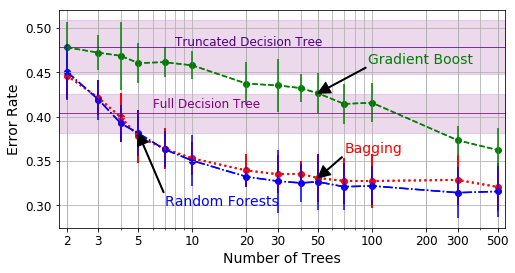

In [37]:
plt.plot(forest_sizes, BAGmu, label="Bagging",ls=":",  lw=2, color="red")
plt.scatter(forest_sizes, BAGmu, color="red")
plt.errorbar(forest_sizes, BAGmu, yerr=1.96*BAGsig, color="red", ls=":", lw=2)

plt.plot(forest_sizes, BoostMeans, label="Gradient Boost",ls="--",color="green")
plt.scatter(forest_sizes, BoostMeans, color="green")
plt.errorbar(forest_sizes,BoostMeans,yerr=1.96*BoostSigmas,color="green",
            ls="--")

plt.plot(forest_sizes, RFMeans, label="Random Forests",ls="-.", color="blue")
plt.scatter(forest_sizes, RFMeans, color="blue")
plt.errorbar(forest_sizes, RFMeans, yerr=1.96*RFSigmas, color="blue",ls="-.")


plt.plot([1,550],[DTFullmu,DTFullmu], # label="Full Decision Tree",
         lw=.75, color="purple")
plt.fill_between([1,550],[DTFullmu-1.96*DTFullsig,DTFullmu-1.96*DTFullsig],
               [DTFullmu+1.96*DTFullsig, DTFullmu+1.96*DTFullsig], 
                 color="purple", alpha=.15)

plt.plot([1,550],[DTTmu,DTTmu], # label="Truncated Decision Tree",
         lw=.75, color="indigo")
plt.fill_between([1,550],[DTTmu-1.96*DTTsig,DTTmu-1.96*DTTsig],
               [DTTmu+1.96*DTTsig, DTTmu+1.96*DTTsig], 
                 color="purple", alpha=.15)
ax=plt.gca()
#plt.legend(fontsize=12)#, ncol=2)
plt.xscale("log")
plt.xticks([1,2,3,5,10,20, 30, 50, 100,200, 300, 500],
           ["1","2","3","5","10","20","30", "50","100","200","300", "500"]);
plt.xlim([1.8,550])
plt.xlabel("Number of Trees",fontsize=14)
plt.ylabel("Error Rate",fontsize=14)
plt.grid(which="both")
ax=plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
plt.text(8,.48,"Truncated Decision Tree", fontsize=12, color="indigo")
plt.text(6,.41,"Full Decision Tree", fontsize=12, color="purple")
plt.annotate(s="Random Forests", xy=(forest_sizes[3],RFMeans[3]),
            color="Blue", fontsize=14,
            xytext=(7,.30),
            arrowprops=dict(facecolor="black", width=1))
plt.annotate(s="Bagging", xy=(forest_sizes[9],BAGmu[9]),
            color="Red", fontsize=14,
            xytext=(70,.36),
            arrowprops=dict(facecolor="black", width=1))
plt.annotate(s="Gradient Boost", xy=(forest_sizes[9],BoostMeans[9]),
            color="Green", fontsize=14,
            xytext=(95,.46),
            arrowprops=dict(facecolor="black", width=1))

fig=plt.gcf()
#fig.tight_layout()
fig.set_size_inches(8,4)
#fig.savefig("white-wine-ensemble-error-vs-number-of-trees.pdf")